# Setup SW4

Took Kate's notebook based on the UO SW4 group work; slurm job and runfile for SW4 from SVI Bostock's NLLoc locs

In [41]:
import numpy as np
from obspy.geodetics.base import gps2dist_azimuth, kilometer2degrees
import pandas as pd
import xarray as xr
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import sw4FileFunctions as sff
base_dir = '/Users/lpapin/Documents/phd/projects/sw4/nonlinloc/'

In [2]:
#SlurmStuff
mem_per_cpu=16 # I fix the memory per cpu and then ramp up the number of tasks
tasks_lowerlim=4 # smalllest number of tasks you want the job to run on, probably gonna be more
percentbuffer=1.30 # Buffer on memory allocation in Slurm, dividing up the calcualtions increases the memory requirement and this stops OOM errors
partition_name="amt" 
time_maximum="3-00:00:00"
account_name="amt" 
# which stations to model ["POHA","HPUD","HSSD","WAID","MLOD","HUAD","KKUD","TOUO","NAGD"]
names=['JRBC','SOKB','GLBC','TSJB','LZB','TWBB','LCBC','TWKB','MGCB','TWGB','KELB','KHVB','SHVB','PGC','PFB','VGZ','SILB','SSIB','YOUB','GOWB','SNB']
# additional model stuff
turn_off_topography = False
simulation_duration=15 #how many seconds do we compute waveforms for
use_velocity3D=True
# output formats
usgsformat=0 # 1 to output textfiles, 0 to sepress output
sacformat=1 # 1 to output sac files, 0 to supress output

## Event and Station locations

In [3]:
# Read in event location file
eventLocs = pd.read_csv(base_dir + 'NLLoc_Bostock/locations.txt',
                        usecols=[0, 1, 2, 3, 4], names=['lfe_family','lat', 'lon', 'depth', 'rms'], header=0)
eventLocs['lfe_family']=eventLocs['lfe_family'].astype(str).str.zfill(3)
eventLocs

,lfe_family,lat,lon,depth,rms
0,001,48.423666,-123.917902,32.372559,0.071229
1,002,48.422867,-123.587693,35.248535,0.102789
2,003,48.184047,-123.526643,30.996419,0.157973
3,005,48.484357,-123.803422,34.521810,0.100317
4,006,48.462685,-123.945840,31.800456,0.061192
...,...,...,...,...,...
125,296,48.378417,-123.492724,37.737956,0.094714
126,297,48.388736,-123.526784,35.696940,0.136967
127,298,48.811199,-123.689150,42.330241,0.098607
128,299,48.885676,-123.880089,40.366536,0.146204


In [4]:
# Multiple events? (if you only have one set this to false so that we dont try to plot those)
multipleEvents=False ###just for the plot but also the limits
#Pick Which Event to Model, or just put your event here
event=eventLocs.loc[eventLocs['lfe_family'] == '001'].squeeze()
print(event)
# In addition to Event Locations Also feed me the maximum frequency you want to model
freqMax=4 #Hz ###

lfe_family           001
lat            48.423666
lon          -123.917902
depth          32.372559
rms             0.071229
Name: 0, dtype: object


In [5]:
stas=pd.read_csv(base_dir+'stations.csv', usecols=[1, 2, 3, 4],
                    names=['sta', 'lat', 'lon', 'elev'], header=0, delimiter='|')
stas

,sta,lat,lon,elev
0,BPCB,48.9236,-123.704500,31.0
1,GLBC,48.3960,-123.636300,100.0
2,JRBC,48.3957,-123.960000,20.0
3,LCBC,48.4834,-124.261900,100.0
4,KHVB,48.5688,-123.466300,39.0
5,MGCB,48.6317,-123.680800,236.0
6,PHYB,49.0828,-123.843100,39.0
7,SHDB,48.7970,-123.636000,55.0
8,SHVB,48.4723,-123.636000,69.0
9,SOKB,48.3947,-123.673100,45.0


In [6]:
# Choose subset of stations
stas=stas.query('sta in @names').reset_index(drop=True)
stas

,sta,lat,lon,elev
0,GLBC,48.3960,-123.6363,100.0
1,JRBC,48.3957,-123.9600,20.0
2,LCBC,48.4834,-124.2619,100.0
3,KHVB,48.5688,-123.4663,39.0
4,MGCB,48.6317,-123.6808,236.0
5,SHVB,48.4723,-123.6360,69.0
6,SOKB,48.3947,-123.6731,45.0
7,TWBB,48.5846,-124.0920,122.0
8,LZB,48.6122,-123.8240,794.0
9,PFB,48.5747,-124.4541,449.0


## Plot Events and Stations

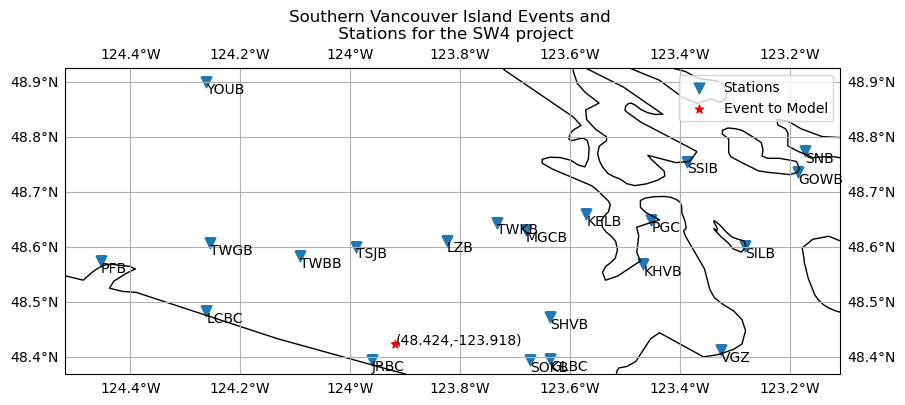

In [7]:
# Plotting the families and the stations
fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
#plt.scatter(stas_full['lon'], stas_full['lat'], marker='v', color='grey', s=50,label='All Stations')
plt.scatter(stas['lon'],stas['lat'],marker='v',s=60,label='Stations')
[plt.text(i, j, f'{name}', va='top', ha='left') for (i, j, name) in zip(stas['lon'], stas['lat'], stas['sta'])]
if multipleEvents:
    plt.scatter(eventLocs['lon'],eventLocs['lat'],marker='o',edgecolors='darkorange',facecolors='orange',label='Event Locations')
plt.scatter(event['lon'],event['lat'],marker='*',facecolors='red',label="Event to Model")
plt.text(event['lon'],event['lat'],f"({event['lat']:.3f},{event['lon']:.3f})")
ax.legend()
ax.coastlines()
gl = ax.gridlines(draw_labels=True)
plt.title('Southern Vancouver Island Events and \n Stations for the SW4 project')
plt.show()

In [8]:
# These values are roughly the rectangle that encompasses all of our points plus a little buffer
Plotlims=ax.get_extent()
lonMin_ini, lonMax_ini, latMin_ini, latMax_ini=Plotlims
# setup points for box for domain from above with only event and stations
x_ini=[Plotlims[0],Plotlims[1],Plotlims[1],Plotlims[0],Plotlims[0]]
y_ini=[Plotlims[2],Plotlims[2],Plotlims[3],Plotlims[3],Plotlims[2]]
print(lonMin_ini, lonMax_ini, latMin_ini, latMax_ini)

-124.51818999999999 -123.10821000000001 48.369385 48.926315


Careful when choosing the event and the stations, if they are too close the limits of the plot might be so close that when filtering you don't get a subset at all from the velocity model.

## 3D Velocity Model

!! Loading as it is and **not** using the inteporlated version used for NLLoc, will see to do that later.

In [9]:
# Load the model and get a subset
velmodel=pd.read_csv(base_dir+'Savard_VpVs.txt', sep='\s+',header=None, names=['lon', 'lat', 'depth', 'vp', 'vs', 'DWS'])
velmodel = velmodel.drop(columns=['DWS'])
print(velmodel, '\nbecomes')
velmodel_subset=velmodel[(velmodel['lat']>=latMin_ini)&(velmodel['lat']<=latMax_ini)&(velmodel['lon']<=lonMax_ini)&(velmodel['lon']>=lonMin_ini)]
velmodel_subset['vp/vs'] = velmodel_subset['vp'] / velmodel_subset['vs']
print(velmodel_subset)

              lon        lat  depth        vp        vs
0     -126.672510  46.951514    0.0  4.956299  2.864755
1     -126.675741  47.077409    0.0  4.966347  2.870762
2     -126.678979  47.203304    0.0  4.976305  2.876411
3     -126.681999  47.320203    0.0  4.968136  2.871618
4     -126.685262  47.446098    0.0  4.957817  2.865878
...           ...        ...    ...       ...       ...
36987 -120.554069  50.494531   93.0  8.245674  4.766323
36988 -120.549634  50.620422   93.0  8.249911  4.768947
36989 -120.545500  50.737325   93.0  8.257427  4.772954
36990 -120.541032  50.863220   93.0  8.261029  4.774880
36991 -120.536556  50.989115   93.0  8.264282  4.776913

[36992 rows x 5 columns] 
becomes
              lon        lat  depth        vp        vs     vp/vs
420   -124.487988  48.426274    0.0  4.170433  2.434671  1.712935
421   -124.488550  48.543172    0.0  5.085475  3.046571  1.669246
422   -124.489160  48.669067    0.0  5.735728  3.433735  1.670405
423   -124.489722  48.785970 

/var/folders/f_/9ygytkln26v3cbhb6ytsqcjc0000gq/T/ipykernel_60794/529848378.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  velmodel_subset['vp/vs'] = velmodel_subset['vp'] / velmodel_subset['vs']


Because we are trying to save memory any place we can, we will take the time to just query the part of the velocity model of interest in hopes that the mimimum Vs in our model space is higher than the absolute minimum Vs in the entire velocity model. We will us the lat and lon limits `_ini` for the inital box before adding the supergrid buffer

In [10]:
# Assign some values from the velocity model for later
# We need Vs min for computing the desired resolution for the domain
# We need the max Vp/Vs ratio, becuase the number of points per wavelength you need for good resolution is higher for high Vp/Vs
vs_min=velmodel_subset['vs'].min()
ind=velmodel_subset.index[velmodel_subset['vp/vs']==velmodel_subset['vp/vs'].max()]
Vp_fromvpvs_max=velmodel['vp'][ind]
Vs_fromvpvs_max=velmodel['vs'][ind]
val=(Vs_fromvpvs_max**2)/(Vp_fromvpvs_max**2-2*Vs_fromvpvs_max**2)
depth_max=velmodel['depth'].max()
val

16845    0.717028
dtype: float64

If val here was <0.1 then we'd have to worry about needing wayyyyy more points per wavelength (like 40 instead of 6-10), but we are okay here

See ref: H.-O. Kreiss and N.A. Petersson. Boundary estimates for the elastic wave equation in almost incompressible materials. SIAM J. Numer. Anal., 50:1556–1580, 2012.

## Plot bounds of Velocity Model with station locations

In [11]:
# Get bounds of velocity model used for the region (cf other notebooks)
# Define latitude, longitude, and depth ranges for the grid
latMin, latMax, lonMin, lonMax = 48, 49.3, -124.9, -123
velmodel_svi = velmodel[(velmodel['lat']>=latMin)&(velmodel['lat']<=latMax)&(velmodel['lon']<=lonMax)&(velmodel['lon']>=lonMin)]
velmodel_svi.sort_values(['lat', 'lon']).reindex()
# get lats and lons for our corners of the vmodel
lon_llc=velmodel_svi[velmodel_svi['lat']==velmodel_svi['lat'].min()]['lon'].min()
lon_lrc=velmodel_svi[velmodel_svi['lat']==velmodel_svi['lat'].min()]['lon'].max()
lon_urc=velmodel_svi[velmodel_svi['lat']==velmodel_svi['lat'].max()]['lon'].max()
lon_ulc=velmodel_svi[velmodel_svi['lat']==velmodel_svi['lat'].max()]['lon'].min()

lat_llc=velmodel_svi['lat'].min()
lat_lrc=velmodel_svi['lat'].min()
lat_urc=velmodel_svi['lat'].max()
lat_ulc=velmodel_svi['lat'].max()

# Construct the values to draw a box
x_vmod=[lon_llc, lon_lrc, lon_urc, lon_ulc, lon_llc]
y_vmod=[lat_llc, lat_lrc, lat_urc, lat_ulc, lat_llc]
print(np.min(x_vmod), np.max(x_vmod))
print(np.min(y_vmod), np.max(y_vmod))

-124.861165 -123.015812
48.057585 49.271562


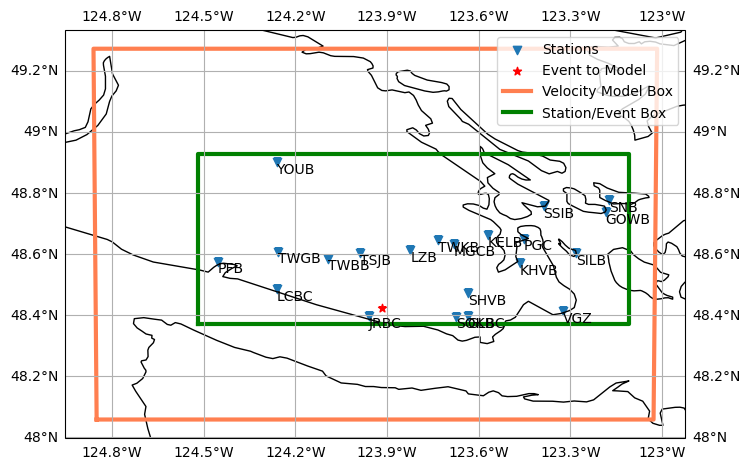

In [12]:
fig=plt.figure(figsize=(8,8))
ax = plt.axes(projection=ccrs.PlateCarree())
plt.scatter(stas['lon'],stas['lat'],marker='v',label='Stations')
# Add station labels
[plt.text(i, j, f'{sta}',va='top',ha='left') for (i, j,sta) in zip(stas['lon'],stas['lat'],stas['sta'])]
if multipleEvents:
    plt.scatter(eventLocs['lon'],eventLocs['lat'],marker='o',edgecolors='darkorange',facecolors='orange',label='Event Locations')
plt.scatter(event['lon'],event['lat'],marker='*',facecolors='red',label="Event to Model")
ax.plot(x_vmod, y_vmod, color='coral',lw=3,label='Velocity Model Box')
ax.plot(x_ini, y_ini, color='green',lw=3,label='Station/Event Box')
gl = ax.gridlines(draw_labels=True)
ax.coastlines()
ax.legend(loc='upper right')
plt.show()

# Here: it works need to check that everything makes sense

## Grid Spacing Math

In [13]:
# This is the relationship from the sw4 manual section 4.5, p 28
# npts should be between 6 and 10

def get_step_size(frequency_max, npts, Vs_min):
    H=Vs_min*1000/(npts*frequency_max)
    return H
    
step_size=get_step_size(freqMax, 10, vs_min)
print(f"Model grid spacing is {step_size} m ")

Model grid spacing is 52.317899999999995 m 


Based on the grid spacing, we can now compute the thickeness of the supergrid layer. The supergrid layers are SUPER important because they help damp reflections on the edges of the domain and dramatically decreases the size of the domain you need and decreases computational time. The supergrid points are PART of your model domain. Default number of supergrid points is 30, less than 20 points will make your solution numerically unstable. Long wavelengths are harder to supress than short wavelengths

In [14]:
npts_supergrid=30
supergrid_thickness=step_size*npts_supergrid
supergrid_thickness_deg=np.round(kilometer2degrees(supergrid_thickness/1000),4)
print(f"Do not put event sources or receivers in the outer {supergrid_thickness} m of the domain \nor a buffer of ~{supergrid_thickness_deg} degrees")

Do not put event sources or receivers in the outer 1569.5369999999998 m of the domain 
or a buffer of ~0.0141 degrees


We care going to add the width of the supergrid as a buffer around our domain

In [15]:
lonMin=lonMin_ini-supergrid_thickness_deg
lonMax=lonMax_ini+supergrid_thickness_deg
latMin=latMin_ini-supergrid_thickness_deg
latMax=latMax_ini+supergrid_thickness_deg

# setup points for box for domain including supergrid buffer
x=[lonMin,lonMax,lonMax,lonMin,lonMin]
y=[latMin,latMin,latMax,latMax,latMin]

In [16]:
print(latMax)

48.940415


## Some topography calculations

First let's draw a box that is slightly bigger than our x,y domain once we've included the supergrid buffer

In [17]:
# setup points for box for domain for elevation if we do adding the buffer from the elevation_snippet script
buffer=0.05
lonMin_topo=lonMin-buffer
lonMax_topo=lonMax+buffer
latMin_topo=latMin-buffer
latMax_topo=latMax+buffer

# setup points for box for topo domain
x_topo=[lonMin_topo,lonMax_topo,lonMax_topo,lonMin_topo,lonMin_topo]
y_topo=[latMin_topo,latMin_topo,latMax_topo,latMax_topo,latMin_topo]

We need to find the minimum and maximum elevations in our topography to calculate zmax

In [18]:
# read topo from netcdf
file2load_topo='VCI_topo_03s.nc'
grid_big = xr.open_dataset(file2load_topo)
grid_big

<xarray.Dataset> Size: 8MB
Dimensions:    (lon: 1671, lat: 1136)
Coordinates:
  * lon        (lon) float64 13kB -124.3 -124.3 -124.3 ... -122.9 -122.9 -122.9
  * lat        (lat) float64 9kB 47.98 47.98 47.98 47.98 ... 48.92 48.92 48.92
Data variables:
    elevation  (lat, lon) float32 8MB ...

In [19]:
grid=grid_big.loc[dict(lat=slice(latMin_topo, latMax_topo),lon=slice(lonMin_topo, lonMax_topo))]
grid['elevation'].data.shape

(744, 1473)

In [20]:
df_grid = grid.to_dataframe().reset_index().sort_values(['lat', 'lon'])
# df_grid_small=df_grid[(df_grid['lat']<=lat_max+buffer)&(df_grid['lat']>=lat_min-buffer)&(df_grid['lon']<=lon_max+buffer)&(df_grid['lon']>=lon_min-buffer)].reset_index().sort_values(['lat', 'lon'])
elev_max=df_grid['elevation'].max()
elev_min=df_grid['elevation'].min()
lontopo_max=df_grid['lon'].max()
lontopo_min=df_grid['lon'].min()
lattopo_max=df_grid['lat'].max()
lattopo_min=df_grid['lat'].min()
print(f"Minimum elevation is {elev_min} m and the maximum elevation is {elev_max} m")

Minimum elevation is -691.0126342773438 m and the maximum elevation is 1314.0 m


Equation for what to set z_max in the topography command:
egrid ≤ emin − 3(emax − emin), emin ≤ e(x, y) ≤ emax

In [21]:
def calc_topo_zmax(emin,emax):
    egrid=emin-3*(emax-emin)
    zmax=-egrid
    return zmax
z_max=calc_topo_zmax(elev_min,elev_max)
z_max

6706.050720214844

## Revisit Velocity Model

We are going to trim the velocity model to be 0.01 degrees bigger than topography model. This is to allow for the fact that sometimes we end up with a little bigger topography model than we call because of how pygmt pulls it's data.

In [22]:
velocity_buffer=0.01
lonMin_vmod_trim=lonMin_topo-velocity_buffer
lonMax_vmod_trim=lonMax_topo+velocity_buffer
latMin_vmod_trim=latMin_topo-velocity_buffer
latMax_vmod_trim=latMax_topo+velocity_buffer

# setup points for box for topo domain
x_vmod_trim=[lonMin_vmod_trim,lonMax_vmod_trim,lonMax_vmod_trim,lonMin_vmod_trim,lonMin_vmod_trim]
y_vmod_trim=[latMin_vmod_trim,latMin_vmod_trim,latMax_vmod_trim,latMax_vmod_trim,latMin_vmod_trim]

## Add topography to our plot

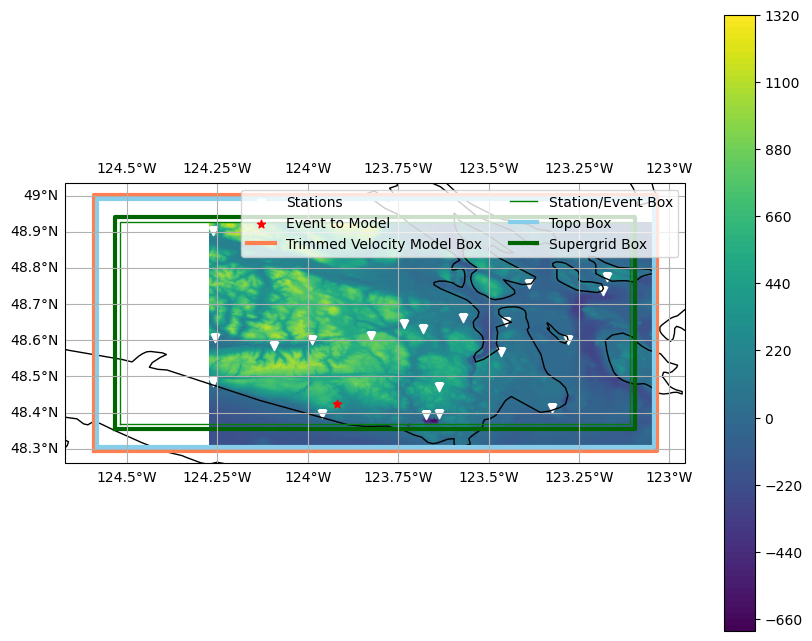

In [23]:
fig=plt.figure(figsize=(10,8))
ax = plt.axes(projection=ccrs.PlateCarree())
plt.contourf(grid.lon, grid.lat,grid.elevation,100)
plt.colorbar()
plt.scatter(stas['lon'],stas['lat'],marker='v',facecolors='white',label='Stations')
# Add station labels
# [plt.text(i, j, f'{sta}',va='top',ha='left') for (i, j,sta) in zip(stas['lon'],stas['lat'],stas['sta'])]
if multipleEvents:
    plt.scatter(eventLocs['lon'],eventLocs['lat'],marker='o',edgecolors='darkorange',facecolors='orange',label='Event Locations')
plt.scatter(event['lon'],event['lat'],marker='*',facecolors='red',label="Event to Model")
ax.plot(x_vmod_trim, y_vmod_trim, color='coral',lw=3,label='Trimmed Velocity Model Box')
ax.plot(x_ini, y_ini, color='green',lw=1,label='Station/Event Box')
ax.plot(x_topo, y_topo, color='skyblue',lw=3,label='Topo Box')
ax.plot(x, y, color='darkgreen',lw=3,label='Supergrid Box')
gl = ax.gridlines(draw_labels=True)
gl.right_labels = False
ax.coastlines()
ax.legend(loc='upper right',ncol=2)
plt.show()

## Aggregate Info for .in Files

Some general definitions 

In [24]:
name=f"svi{names[0]}"

### Grid Command info

Specifying the coordinates for grid on surface

In [25]:
# Compute cartesian locations for source
X,_,_= gps2dist_azimuth(latMin, lonMin, latMin, lonMax)
Y,_,_= gps2dist_azimuth(latMin, lonMin, latMax, lonMin)
X,Y=np.round(X,-1),np.round(Y,-1)
print(f"x and y in m {Y,X }")
print(f"lat lon of lower left corner {latMin:.3f},{lonMin:.3f}")
print(f"lat lon of upper right corner {latMax:.3f},{lonMax:.3f}")
print(f"Model grid spacing should be at least {step_size:.0f} m for a frequency max of {freqMax} Hz")

x and y in m (65070.0, 106580.0)
lat lon of lower left corner 48.355,-124.532
lat lon of upper right corner 48.940,-123.094
Model grid spacing should be at least 52 m for a frequency max of 4 Hz


/var/folders/f_/9ygytkln26v3cbhb6ytsqcjc0000gq/T/ipykernel_60794/503445679.py:2: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  X,_,_= gps2dist_azimuth(latMin, lonMin, latMin, lonMax)
/var/folders/f_/9ygytkln26v3cbhb6ytsqcjc0000gq/T/ipykernel_60794/503445679.py:3: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  Y,_,_= gps2dist_azimuth(latMin, lonMin, latMax, lonMin)


For the model depth I'm using the event depth plus a buffer of 2 times the width of the supergrid layer. I made that up

In [26]:
print(f"Maximum depth based on velocity model {depth_max} km")
domainDepth=np.round((np.abs(event['depth']*1000)+2*supergrid_thickness),-3)
print(f"We are using {domainDepth/1000} km as the depth of our model")

Maximum depth based on velocity model 93.0 km
We are using 36.0 km as the depth of our model


In [27]:
grid_cmd=f"grid x={Y} y={X} z={domainDepth} lat={latMin:.3f} lon={lonMin:.3f} az=0 h={step_size:.0f}\n"
print(grid_cmd)

grid x=65070.0 y=106580.0 z=36000.0 lat=48.355 lon=-124.532 az=0 h=52



### Material Model Command Info

In [28]:
if use_velocity3D:
    sff.generate_pfile(velmodel, name, lonMin_vmod_trim, lonMax_vmod_trim, latMin_vmod_trim, latMax_vmod_trim)

In [29]:
block_cmd=""
#mod1D=mod1D[mod1D.depth<=domainDepth/1000]
#for i, row in mod1D.iterrows():
#    if i==0:
#        text=f"block vp={row.vp*1000:.1f} vs={row.vs*1000:.1f} rho={row.rho*1000:.1f}\n"
#    else:
#        text=f"block vp={row.vp*1000:.1f} vs={row.vs*1000:.1f} rho={row.rho*1000:.1f} z1={row.depth*1000:.1f}\n"
#    block_cmd=block_cmd+text
if use_velocity3D:
    pfile_cmd=f"{block_cmd}pfile filename={name}.ppmod\n"
else:
    pfile_cmd=block_cmd
print(pfile_cmd)

pfile filename=sviJRBC.ppmod



### Topography Command Info#

zmax is the value that sw4 uses for making its curvilinear grid

In [30]:
print(f"zmax is {np.round(z_max,3)}")

zmax is 6706.051


Generate the smaller topography file ending in `.topo` from netcdf file that is the size of the velocity model

In [31]:
sff.write_topo(file2load_topo, name, lonMin_topo, lonMax_topo, latMin_topo, latMax_topo)

In [32]:
topo_cmd=f"topography input=grid file={name}.topo zmax={z_max:.3f} order=3\n"
print(topo_cmd)

topography input=grid file=sviJRBC.topo zmax=6706.051 order=3



### Source Command Info

I'm making numerical green's functions so I run each of the six components of the MT 

In [33]:
sourcetype="Dirac"
moment=1.0
gf_components=["mxx","myy","mzz","mxy","mxz","myz"]
eventLat, eventLon=event['lat'], event['lon']
eventDepth=np.abs(event['depth']*1000)
source_cmd_list=[]
for comp in gf_components:
    src_cmd=f"source lat={eventLat:.3f} lon={eventLon:.3f} depth={eventDepth}  {comp}={moment} type=Dirac t0=0\n"
    source_cmd_list.append(src_cmd)
    print(src_cmd)

source lat=48.424 lon=-123.918 depth=32372.559  mxx=1.0 type=Dirac t0=0

source lat=48.424 lon=-123.918 depth=32372.559  myy=1.0 type=Dirac t0=0

source lat=48.424 lon=-123.918 depth=32372.559  mzz=1.0 type=Dirac t0=0

source lat=48.424 lon=-123.918 depth=32372.559  mxy=1.0 type=Dirac t0=0

source lat=48.424 lon=-123.918 depth=32372.559  mxz=1.0 type=Dirac t0=0

source lat=48.424 lon=-123.918 depth=32372.559  myz=1.0 type=Dirac t0=0



### Receiver Output Command Info

In [34]:
# set output type
out='displacement'

In [35]:
rec_cmd_list=[]
for comp in gf_components:
    rec_cmd=""
    for i in range(len(stas)):
        rec_cmd=rec_cmd+f"rec lat={stas['lat'][i]:.3f} lon={stas['lon'][i]:.3f} depth=0 nsew=1 variables={out} file={stas['sta'][i]}_{comp} usgsformat={usgsformat} sacformat={sacformat}\n"
    print(rec_cmd)
    rec_cmd_list.append(rec_cmd)

rec lat=48.396 lon=-123.636 depth=0 nsew=1 variables=displacement file=GLBC_mxx usgsformat=0 sacformat=1
rec lat=48.396 lon=-123.960 depth=0 nsew=1 variables=displacement file=JRBC_mxx usgsformat=0 sacformat=1
rec lat=48.483 lon=-124.262 depth=0 nsew=1 variables=displacement file=LCBC_mxx usgsformat=0 sacformat=1
rec lat=48.569 lon=-123.466 depth=0 nsew=1 variables=displacement file=KHVB_mxx usgsformat=0 sacformat=1
rec lat=48.632 lon=-123.681 depth=0 nsew=1 variables=displacement file=MGCB_mxx usgsformat=0 sacformat=1
rec lat=48.472 lon=-123.636 depth=0 nsew=1 variables=displacement file=SHVB_mxx usgsformat=0 sacformat=1
rec lat=48.395 lon=-123.673 depth=0 nsew=1 variables=displacement file=SOKB_mxx usgsformat=0 sacformat=1
rec lat=48.585 lon=-124.092 depth=0 nsew=1 variables=displacement file=TWBB_mxx usgsformat=0 sacformat=1
rec lat=48.612 lon=-123.824 depth=0 nsew=1 variables=displacement file=LZB_mxx usgsformat=0 sacformat=1
rec lat=48.575 lon=-124.454 depth=0 nsew=1 variables=dis

### Other Command Info

In [36]:
fileio_cmd_list=[]
infilename_list=[]
verbosity=0
for comp in gf_components:
    outdir=name+"_results_"+comp
    fileio_cmd=f"fileio path={outdir} verbose={verbosity}\n"
    print(fileio_cmd)
    fileio_cmd_list.append(fileio_cmd)

    infilename=f"{name}_{comp}"
    infilename_list.append(infilename)
    print(infilename+'.in')

time_cmd=f"time t={simulation_duration} \n"

fileio path=sviJRBC_results_mxx verbose=0

sviJRBC_mxx.in
fileio path=sviJRBC_results_myy verbose=0

sviJRBC_myy.in
fileio path=sviJRBC_results_mzz verbose=0

sviJRBC_mzz.in
fileio path=sviJRBC_results_mxy verbose=0

sviJRBC_mxy.in
fileio path=sviJRBC_results_mxz verbose=0

sviJRBC_mxz.in
fileio path=sviJRBC_results_myz verbose=0

sviJRBC_myz.in


## Some last Calculations before making files

### Memory Calculations

Appendix B says roughly 208 bytes/grid point for runs with topography 

BUT "For parallel runs, the memory per grid point will be somewhat higher, because of duplicatedghost points at the processor boundaries."

In [37]:
grid_pts=(X/step_size)*(Y/step_size)*(domainDepth/step_size)
mem_per_point=208
mem_gb=np.round(grid_pts*mem_per_point/1e9,2)
print(f"Rough approximation of memory is {mem_gb} GB for a maximum frequency of {freqMax} Hz")
min_tasks=np.max([np.ceil(mem_gb*percentbuffer/mem_per_cpu),tasks_lowerlim])
print(f"{min_tasks} is the smallest number of tasks we can assign")
tot_mem=mem_per_cpu*(min_tasks)
print(f"{tot_mem} total memory request")

Rough approximation of memory is 362.64 GB for a maximum frequency of 4 Hz
30.0 is the smallest number of tasks we can assign
480.0 total memory request


### Maximum Grid spacing

To have 30 super grid points on the outside of the domain and at least 60 actual grid points in domain, you can't have a step size for your grid higher than:

In [38]:
h_max=np.min([X/120,Y/120,depth_max*1000/90])
h_max

542.25

## Write .in file

In [39]:
if turn_off_topography:
    # this line will comment out the topography command if you need to
    topo_cmd= ("#"+topo_cmd)
for i, fname in enumerate(infilename_list):
    fname = fname+".in"
    file=open(fname,'w')
    file.write(f"# SW4 input file \n"+
                "# The grid command defines the model domain \n"+
                grid_cmd+
                "# The fileio command specifies output directory and how much text the code spits out while it runs \n"+
                fileio_cmd_list[i]+
                "# The topography reads in the topography model we use \n"+
                topo_cmd+
                "# The pfile command reads the velocity model in \n"+
                pfile_cmd+
                "# the source sets up the event information \n"+
                source_cmd_list[i]+
                "# The time command sets model start time (certain STFs require t0>0 to avoid numerical nonsense) \n"+
                time_cmd+
                "# The rec command set where stations are \n"+
                rec_cmd_list[i])
    file.close()

## Settings

## Write Slurm

In [40]:
partitionline=f"#SBATCH --partition={partition_name}     ### Quality of Service (like a queue in PBS)\n"
timeline=f"#SBATCH --time={time_maximum}      ### Wall clock time limit in Days-HH:MM:SS\n"
taskline=f"#SBATCH --ntasks={int(min_tasks)}     ### Number of tasks to be launched per Node\n"
memoryline=f"#SBATCH --mem-per-cpu={int(mem_per_cpu)}G\n"
accountline=f"#SBATCH --account={account_name}\n"
mailline1="#SBATCH --mail-type=END,FAIL\n"
mailline2="#SBATCH --mail-user=lpapin@uoregon.edu\n\n"
for i, fname in enumerate(infilename_list):
    fname_slurm="submit_"+fname
    fname_in=fname+".in"
    jobname="sw4"+str(i)+stas['sta'][0]
    jobnameline=f"#SBATCH --job-name={jobname}    ### Job Name\n"
    runline=f"mpirun -np $SLURM_NTASKS sw4 {fname_in}"
    file=open(fname_slurm,'w')
    file.write(f"#!/bin/bash\n"+
               jobnameline+
               partitionline+
               timeline+
               taskline+
               memoryline+
               accountline+
               mailline1+
               mailline2+
               f"module load sw4/3.0.0\n"+
               runline)
    file.close()